# Simulador virus machine

#### En este notebook se representa algunas versiones del simulador con algunas pruebas y tiempos. 
#### Cada modelo está escrito en su respectivo notebook en /src/

In [1]:
import math
import random
from numba import cuda,jit,njit
import numpy as np
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import time
import matplotlib.pyplot as plt   
import sys
import os
sys.path.append("/home/servelgar/tfg-cuda/vm/examples")
sys.path.append("/home/servelgar/tfg-cuda/vm/src")
sys.path.append("/home/servelgar/tfg-cuda/vm/tests")
print(sys.path)
from basicprobabilistic import basicprobabilistic
from spsuma import spsuma


/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/random.py:45: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(forceobj=_forceobj, looplift=_looplift)
/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/random.py:71: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(forceobj=_forceobj, looplift=_looplift)
/home/servelgar/.local/lib/pyt

['/home/servelgar/tfg-cuda', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/servelgar/.local/lib/python3.9/site-packages', '/usr/local/lib64/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages', '/home/servelgar/tfg-cuda/vm/examples', '/home/servelgar/tfg-cuda/vm/src', '/home/servelgar/tfg-cuda/vm/tests']


# basicprobabilistic CPU - JIT

In [2]:
@njit
def cpu_simulaciones(n,p,array_sims):
    
    cdf = np.array([p,(p+(1-p))])
    
    for i in range(array_sims.shape[0]):
        for j in range(n):
            array_sims[i][0] -= 1
            rnd = random.random()
            index = 0
            while rnd > cdf[index]:
                index += 1
            array_sims[i][index+1] += 1
    
    return array_sims



In [3]:
@njit
def probabilistic_acum(array_sims,n):
    array_media = np.zeros((n_sims,2), dtype = np.float64)
    
    for j in range(1,array_sims.shape[1]):
        tmp = 0
        for i in range(array_sims.shape[0]):
            tmp += array_sims[i][j]
            media = tmp / ((i+1)*n)
            array_media[i][j-1] = media
    
    return array_media

In [5]:
n_sims = 10000  # numero de computaciones de maquinas virus

n = 10000  #número de virus
p = 0.5  #probabilidad

array_sims = np.zeros((n_sims,3), dtype=np.float64)
array_sims[:,0] = n

In [7]:
n_sims = 100  # numero de computaciones de maquinas virus

n = 100  #número de virus
p = 0.5  #probabilidad
array_sims = np.zeros((n_sims,3), dtype=np.float64)
array_sims[:,0] = n

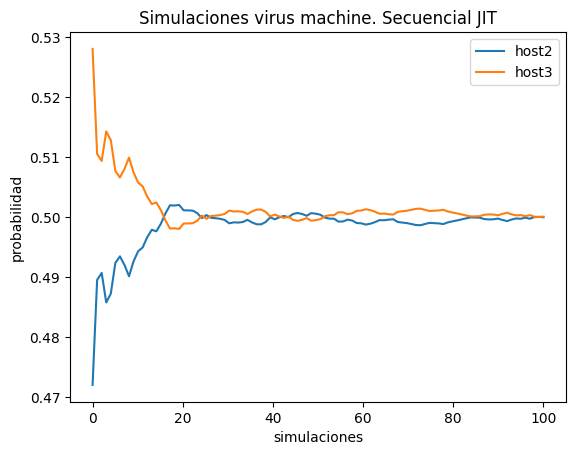

In [44]:
x = np.linspace(0,n_sims,n_sims)
y1 = array_media[:,0]
y2 = array_media[:,1]

plt.plot(x,y1, label='host2')
plt.plot(x,y2, label='host3')


plt.title("Simulaciones virus machine. Secuencial JIT")
plt.xlabel("simulaciones")
plt.ylabel("probabilidad")
plt.legend()

plt.show()

In [8]:
array_medias = cpu_simulaciones(n,p,array_sims)
a = probabilistic_acum(array_sims,n)
print(a[len(a)-1])

[0.4985 0.5015]


In [6]:
%timeit cpu_simulaciones(n,p,array_sims)

951 ms ± 589 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit probabilistic_acum(array_sims,n)

239 µs ± 653 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# basicprobabilistic CPU - sin JIT

In [18]:
n_sims = 10000  # numero de computaciones de maquinas virus

n = 10000  #número de virus
p = 0.5  #probabilidad

In [19]:
def cpu_simulaciones_sinJIT(n_sims, n, p):
    i = 0
    vm = basicprobabilistic(n, p)
    l_prob = [[0,0]]
    while i < n_sims:
        (uh, lista_compute) = vm.compute()
        p1 = lista_compute[1] 
        p2 = lista_compute[2] 
        l_prob.append([p1, p2])
        i += 1
        vm.restart()
    l_prob.pop(0)
    return l_prob

In [4]:
def cpu_probabilidades(l_prob):
    acum1 = 0
    acum2 = 0
    l_res = []
    for i in range(len(l_prob)):
        acum1 += l_prob[i][0]
        acum2 += l_prob[i][1]
        media1 = acum1 / ((i+1)*n)
        media2 = acum2 / ((i+1)*n)
        l_res.append([media1,media2])
    return l_res

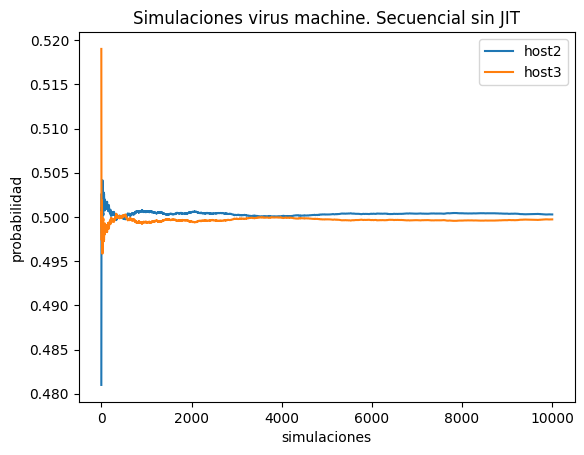

In [16]:
l_prob = cpu_simulaciones_sinJIT(n_sims, n, p)
prob_acum = cpu_probabilidades(l_prob)
x = np.linspace(0,n_sims,n_sims)
y1 = [compression[0] for compression in prob_acum[0:]]
y2 = [compression[1] for compression in prob_acum[0:]]

plt.plot(x,y1, label='host2')
plt.plot(x,y2, label='host3')


plt.title("Simulaciones virus machine. Secuencial sin JIT")
plt.xlabel("simulaciones")
plt.ylabel("probabilidad")
plt.legend()

plt.show()

In [ ]:

%timeit cpu_simulaciones_sinJIT(n_sims,n,p)  


# basicprobabilistic - NUMBA CUDA

In [4]:
########## VARIABLES #########
n = 1000  # numero de viruses
n_sim = 100  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,3), dtype=np.float64)
array_sims[:,0] = n
#array_media = np.zeros((n_sim,2), dtype = np.float64)

In [5]:
@cuda.jit
def kernel_compute(array_sims,p, rng_state, n):
    x = cuda.threadIdx.x

    columna = cuda.blockDim.x * cuda.blockIdx.x + x

    cdf = cuda.local.array(shape=2, dtype=np.float64)
    cdf[0] = p
    cdf[1] = p + (1-p)
    
    # COMPUTE
    if columna < array_sims.shape[0]:
        for i in range(n):
            cuda.atomic.add(array_sims, (columna, 0), -1.0)
            #rnd = array_random[columna][i]
            rnd = xoroshiro128p_uniform_float32(rng_state, columna)
            index = 0
            while rnd > cdf[index]:
                index += 1
            cuda.atomic.add(array_sims, (columna, index+1), 1.0)
    
    cuda.syncthreads()

In [6]:
@njit
def probabilistic_acum(array_sims,n):
    array_media = np.zeros((n_sim,2), dtype = np.float64)
    
    for j in range(1,array_sims.shape[1]):
        tmp = 0
        for i in range(array_sims.shape[0]):
            tmp += array_sims[i][j]
            media = tmp / ((i+1)*n)
            array_media[i][j-1] = media
    
    return array_media

In [7]:
def solucion_basicprobabilistic_sims(array_sims):
    tam = array_sims.shape[0]
    s = f"basicprobabilistic: {tam} simulaciones\n"
    s += f"nº virus: {n}\n"
    s += f"probabilidad de pasar a host2: {p*100} %\n"
    s += f"probabilidad de pasar a host3: {(1-p)*100} %\n"
    s += "----------------------------------------\n"
    if (tam <= 10):
        for i in range(array_sims.shape[0]):
            s += f"Simulación: {i+1}\n"
            s += "HOST 1 | HOST 2 | HOST 3\n"
            s += f"{array_sims[i][0]} | {array_sims[i][1]} | {array_sims[i][2]}\n"
            s += "++++++++++++++++++++++++++++++++++\n"
    else:
        tam = 5
        for i in range(tam):
            s += f"Simulación: {i+1}\n"
            s += "HOST 1 | HOST 2 | HOST 3\n"
            s += f"{array_sims[i][0]} | {array_sims[i][1]} | {array_sims[i][2]}\n"
            s += "++++++++++++++++++++++++++++++++++\n"
        for i in range(tam,0,-1):
            if i == tam:
                s += ".\n"
                s += ".\n"
                s += ".\n"
            s += f"Simulación: {array_sims.shape[0]-i + 1}\n"
            s += "HOST 1 | HOST 2 | HOST 3\n"
            s += f"{array_sims[array_sims.shape[0]-i-1][0]} | {array_sims[array_sims.shape[0]-i-1][1]} | {array_sims[array_sims.shape[0]-i-1][2]}\n"
            s += "++++++++++++++++++++++++++++++++++\n"
    return s

In [8]:
def solucion_basicprobabilistic_medias(array_media):
    tam = array_media.shape[0]
    s = f"basicprobabilistic: {tam} simulaciones\n"
    s += "probabilidad acumulada entre simulaciones\n"
    s += "probabilidad teórica: \n"
    s += f"host2: {p*100} % | host3: {(1-p)*100} %\n"
    s += "----------------------------------------\n"
    if(tam <= 10):
        for i in range(array_media.shape[0]):
            s += f"Simulación: {i+1}\n"
            s += "PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3\n"
            s += f"  {array_media[i][0]*100} % |     {array_media[i][1]*100} %\n"
            s += "++++++++++++++++++++++++++++++++++\n"
    else:
        tam = 5
        for i in range(tam):
            s += f"Simulación: {i+1}\n"
            s += "PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3\n"
            s += f"  {array_media[i][0]*100} % |     {array_media[i][1]*100} %\n"
            s += "++++++++++++++++++++++++++++++++++\n"
        for i in range(tam,0,-1):
            if i == tam:
                s += ".\n"
                s += ".\n"
                s += ".\n"
            s += f"Simulación: {array_media.shape[0] - i + 1}\n"
            s += "PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3\n"
            s += f"    {array_media[array_media.shape[0]-i-1][0]*100} % |     {array_media[array_media.shape[0]-i-1][1]*100} %\n"
            s += "++++++++++++++++++++++++++++++++++\n"
    return s

In [9]:
############ INICIALIZACION DE HILOS, ETC #################
cuda.select_device(0)
threads_per_block = 1024
#blocks_per_grid1 = ((n_sim + (threads_per_block - 1)) // threads_per_block, (n + threads_per_block -1) // threads_per_block)
blocks_per_grid2 = ((n_sim + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
rng_states = create_xoroshiro128p_states(threads_per_block * blocks_per_grid2[0], seed=time.time())

################### LAUNCH Y PRINT #####################
d_array_sims = cuda.to_device(array_sims)

kernel_compute[blocks_per_grid2, threads_per_block](d_array_sims,p, rng_states, n)
cuda.synchronize()
array_sims = d_array_sims.copy_to_host()

array_media = probabilistic_acum(array_sims,n)

#print(array_sims)
#print("#####################################")
#print("#####################################")
#print(array_media)

/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [10]:
print(solucion_basicprobabilistic_sims(array_sims))

basicprobabilistic: 100 simulaciones
nº virus: 1000
probabilidad de pasar a host2: 50.0 %
probabilidad de pasar a host3: 50.0 %
----------------------------------------
Simulación: 1
HOST 1 | HOST 2 | HOST 3
0.0 | 510.0 | 490.0
++++++++++++++++++++++++++++++++++
Simulación: 2
HOST 1 | HOST 2 | HOST 3
0.0 | 498.0 | 502.0
++++++++++++++++++++++++++++++++++
Simulación: 3
HOST 1 | HOST 2 | HOST 3
0.0 | 523.0 | 477.0
++++++++++++++++++++++++++++++++++
Simulación: 4
HOST 1 | HOST 2 | HOST 3
0.0 | 486.0 | 514.0
++++++++++++++++++++++++++++++++++
Simulación: 5
HOST 1 | HOST 2 | HOST 3
0.0 | 482.0 | 518.0
++++++++++++++++++++++++++++++++++
.
.
.
Simulación: 96
HOST 1 | HOST 2 | HOST 3
0.0 | 511.0 | 489.0
++++++++++++++++++++++++++++++++++
Simulación: 97
HOST 1 | HOST 2 | HOST 3
0.0 | 512.0 | 488.0
++++++++++++++++++++++++++++++++++
Simulación: 98
HOST 1 | HOST 2 | HOST 3
0.0 | 483.0 | 517.0
++++++++++++++++++++++++++++++++++
Simulación: 99
HOST 1 | HOST 2 | HOST 3
0.0 | 496.0 | 504.0
++++++++++

In [11]:
print(solucion_basicprobabilistic_medias(array_media))

basicprobabilistic: 100 simulaciones
probabilidad acumulada entre simulaciones
probabilidad teórica: 
host2: 50.0 % | host3: 50.0 %
----------------------------------------
Simulación: 1
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  51.0 % |     49.0 %
++++++++++++++++++++++++++++++++++
Simulación: 2
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  50.4 % |     49.6 %
++++++++++++++++++++++++++++++++++
Simulación: 3
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  51.03333333333333 % |     48.96666666666666 %
++++++++++++++++++++++++++++++++++
Simulación: 4
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  50.425 % |     49.575 %
++++++++++++++++++++++++++++++++++
Simulación: 5
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  49.980000000000004 % |     50.019999999999996 %
++++++++++++++++++++++++++++++++++
.
.
.
Simulación: 96
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
    50.06315789473684 % |     49.93684210526316 %
++++++++++++++++++++++++++++++++++
Simulación: 97
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
    50.075 % 

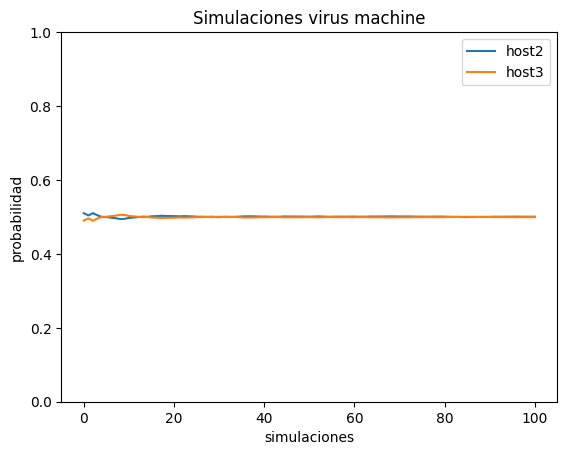

In [12]:
x = np.linspace(0,n_sim,n_sim)
y1 = array_media[:,0]
y2 = array_media[:,1]

plt.plot(x,y1, label='host2')
plt.plot(x,y2, label='host3')


plt.title("Simulaciones virus machine")
plt.xlabel("simulaciones")
plt.ylabel("probabilidad")
plt.legend()

plt.ylim(0,1)

plt.show()

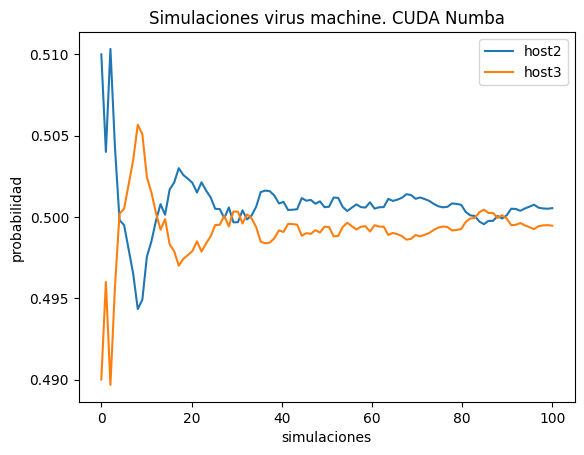

In [13]:
plt.plot(x,y1, label='host2')
plt.plot(x,y2, label='host3')


plt.title("Simulaciones virus machine. CUDA Numba")
plt.xlabel("simulaciones")
plt.ylabel("probabilidad")
plt.legend()

plt.show()

# spsuma - secuencial 

In [3]:
n1 = 60
n2 = 40
vm = spsuma(n1,n2)
vm.compute(verbose = 2, steps = 62)

C_{0} = [60, 40, [2, 1], 0]
C_{1} = [59, 39, [2, 1], 2]
C_{2} = [58, 38, [2, 1], 4]
C_{3} = [57, 37, [2, 1], 6]
C_{4} = [56, 36, [2, 1], 8]
C_{5} = [55, 35, [2, 1], 10]
C_{6} = [54, 34, [2, 1], 12]
C_{7} = [53, 33, [2, 1], 14]
C_{8} = [52, 32, [2, 1], 16]
C_{9} = [51, 31, [2, 1], 18]
C_{10} = [50, 30, [2, 1], 20]
C_{11} = [49, 29, [2, 1], 22]
C_{12} = [48, 28, [2, 1], 24]
C_{13} = [47, 27, [2, 1], 26]
C_{14} = [46, 26, [2, 1], 28]
C_{15} = [45, 25, [2, 1], 30]
C_{16} = [44, 24, [2, 1], 32]
C_{17} = [43, 23, [2, 1], 34]
C_{18} = [42, 22, [2, 1], 36]
C_{19} = [41, 21, [2, 1], 38]
C_{20} = [40, 20, [2, 1], 40]
C_{21} = [39, 19, [2, 1], 42]
C_{22} = [38, 18, [2, 1], 44]
C_{23} = [37, 17, [2, 1], 46]
C_{24} = [36, 16, [2, 1], 48]
C_{25} = [35, 15, [2, 1], 50]
C_{26} = [34, 14, [2, 1], 52]
C_{27} = [33, 13, [2, 1], 54]
C_{28} = [32, 12, [2, 1], 56]
C_{29} = [31, 11, [2, 1], 58]
C_{30} = [30, 10, [2, 1], 60]
C_{31} = [29, 9, [2, 1], 62]
C_{32} = [28, 8, [2, 1], 64]
C_{33} = [27, 7, [2, 1], 66

(62, [0, 0, [2], 100])

In [4]:
%timeit vm.compute(verbose = 0, steps = 62)

846 ns ± 7.73 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


# spsuma - CUDA NUMBA

In [5]:
@cuda.jit
def kernel_compute(array_comp, initial_instructions):
    x = cuda.threadIdx.x
    columna = cuda.blockDim.x * cuda.blockIdx.x + x
    
    # recorrer la matriz a mano, paralelización por cada step.
    for i in range(1, array_comp.shape[0]):
        if(array_comp[i-1][0] != 0 and array_comp[i-1][1] != 0):
            if (columna < initial_instructions.shape[0]):   
                array_comp[i][columna] = array_comp[i-1][columna] - 1
                array_comp[i][2] = array_comp[i-1][2] + initial_instructions.shape[0] # sin pesos, voy a sumar la cantidad de instrucciones que se activen
                array_comp[i][3] = 2
        elif(array_comp[i-1][0] == 0 and array_comp[i-1][1] == 0):
            sol = array_comp[i-1][2]
            if (columna < array_comp.shape[0] - i):
                array_comp[columna + i][2] = sol
                array_comp[columna + i][3] = -1
        else:
            # mono instrucción por step:
            if (array_comp[i-1][0] == 0 and array_comp[i-1][1] != 0):
                array_comp[i][1] = array_comp[i-1][1] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 1
            
            elif(array_comp[i-1][1] == 0 and array_comp[i-1][0] != 0):
                array_comp[i][0] = array_comp[i-1][0] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 0
        cuda.syncthreads()
                
                
                 #[15  5 30  2]
                 #[14  4 32  2]
                 #[13  3 33  1]

In [6]:
def solucion_spsuma_cuda(array_comp):
    tam = array_comp.shape[0]
    s = f"sofparallel suma: {n_steps} steps\n"
    s += f"--STEP 0--\n"
    s += f"nº virus HOST 1: {n1}\n"
    s += f"nº virus HOST 2: {n2}\n"
    s += f"Actividades en paralelo: (i1, i2)\n"
    if tam <= 10:
        for i in range(1,tam):
            s += f"--STEP {i}--\n"
            if (array_comp[i][3] == 2):
                s += "Actividades en paralelo: (i1,i2)\n"
            elif (array_comp[i][3] == 1):
                s += "Actividad: i2\n"
            elif (array_comp[i][3] == 0):
                s += "Actividad: i1\n"
            else:
                s += "Actividad i3.\n"
                s += "FINAL DE LA SIMULACION\n"

            s += f"| HOST 1 | HOST 2 | HOST 3 |\n"
            s += f"|    {array_comp[i][0]}    |    {array_comp[i][1]}    |    {array_comp[i][2]}    |\n"
    else:
        for i in range(5):
            s += f"--STEP {i+1}--\n"
            if (array_comp[i][3] == 2):
                s += "Actividades en paralelo: (i1,i2)\n"
            elif (array_comp[i][3] == 1):
                s += "Actividad: i2\n"
            elif (array_comp[i][3] == 0):
                s += "Actividad: i1\n"
            else:
                s += "Actividad: i3.\n"
                s += "FINAL DE LA SIMULACION\n"

            s += f"| HOST 1 | HOST 2 | HOST 3 |\n"
            s += f"|    {array_comp[i][0]}    |    {array_comp[i][1]}    |    {array_comp[i][2]}    |\n"
            
        for i in range(tam-5,tam):
            if(i == (tam-5)):
                s += ".\n"
                s += ".\n"
                s += ".\n"
            s += f"--STEP {i+1}--\n"
            if (array_comp[i-1][3] == 2):
                s += "Actividades en paralelo: (i1,i2)\n"
            elif (array_comp[i-1][3] == 1):
                s += "Actividad: i2\n"
            elif (array_comp[i-1][3] == 0):
                s += "Actividad: i1\n"
            else:
                s += "Actividad: i3\n"
                s += "FINAL DE LA SIMULACION\n"

            s += f"| HOST 1 | HOST 2 | HOST 3 |\n"
            s += f"|     {array_comp[i-1][0]}    |     {array_comp[i-1][1]}    |    {array_comp[i-1][2]}    |\n"
                  
    return s

In [36]:
n1 = 5
n2 = 4

n_steps = 6
initial_instructions = np.array([0, 1]) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)

array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2

In [37]:
cuda.select_device(0)
threads_per_block = 1024
#blocks_per_grid1 = ((n_sim + (threads_per_block - 1)) // threads_per_block, (n + threads_per_block -1) // threads_per_block)
blocks_per_grid2 = ((initial_instructions.shape[0] + (threads_per_block - 1)) // threads_per_block, (3 + threads_per_block -1) // threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [38]:
kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)
array_comp = d_array_comp.copy_to_host()
#print(array_comp)
print(solucion_spsuma_cuda(array_comp))

sofparallel suma: 6 steps
--STEP 0--
nº virus HOST 1: 5
nº virus HOST 2: 4
Actividades en paralelo: (i1, i2)
--STEP 1--
Actividades en paralelo: (i1,i2)
| HOST 1 | HOST 2 | HOST 3 |
|    4    |    3    |    2    |
--STEP 2--
Actividades en paralelo: (i1,i2)
| HOST 1 | HOST 2 | HOST 3 |
|    3    |    2    |    4    |
--STEP 3--
Actividades en paralelo: (i1,i2)
| HOST 1 | HOST 2 | HOST 3 |
|    2    |    1    |    6    |
--STEP 4--
Actividades en paralelo: (i1,i2)
| HOST 1 | HOST 2 | HOST 3 |
|    1    |    0    |    8    |
--STEP 5--
Actividad: i1
| HOST 1 | HOST 2 | HOST 3 |
|    0    |    0    |    9    |



In [31]:
array_comp = np.zeros((n_steps,4), dtype=np.int64)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)

In [32]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

33.4 µs ± 18.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# SPNUMBA v2

In [ ]:
@cuda.jit
def kernel_compute(array_comp, initial_instructions):
    x = cuda.threadIdx.x
    fila = cuda.blockDim.x * cuda.blockIdx.x + x
    
    y = cuda.threadIdx.y
    columna = cuda.blockDim.y * cuda.blockIdx.y + y
    
    if fila >= array_comp.shape[0] and columna >= array_comp.shape[1]:
        return
    ç?? ?
    
    
    # recorrer la matriz a mano, paralelización por cada step.
    for i in range(1, array_comp.shape[0]):
        if(array_comp[i-1][0] != 0 and array_comp[i-1][1] != 0):
            if (columna < initial_instructions.shape[0]):   
                array_comp[i][columna] = array_comp[i-1][columna] - 1
                array_comp[i][2] = array_comp[i-1][2] + initial_instructions.shape[0] # sin pesos, voy a sumar la cantidad de instrucciones que se activen
                array_comp[i][3] = 2
        elif(array_comp[i-1][0] == 0 and array_comp[i-1][1] == 0):
            sol = array_comp[i-1][2]
            if (columna < array_comp.shape[0] - i):
                array_comp[columna + i][2] = sol
                array_comp[columna + i][3] = -1
        else:
            # mono instrucción por step:
            if (array_comp[i-1][0] == 0 and array_comp[i-1][1] != 0):
                array_comp[i][1] = array_comp[i-1][1] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 1
            
            elif(array_comp[i-1][1] == 0 and array_comp[i-1][0] != 0):
                array_comp[i][0] = array_comp[i-1][0] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 0
        cuda.syncthreads()